In [1]:
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [2]:
# Load training data on Housing Prices in DC.
train_data = pd.read_csv("/Users/abhatti/Documents/06_coding_discussion/train_data.csv")
train_data.shape

(43590, 39)

In [3]:
# Load test data on Housing Prices in DC.
test_data = pd.read_csv("/Users/abhatti/Documents/06_coding_discussion/test_data.csv")
test_data.shape

(14531, 39)

<AxesSubplot:>

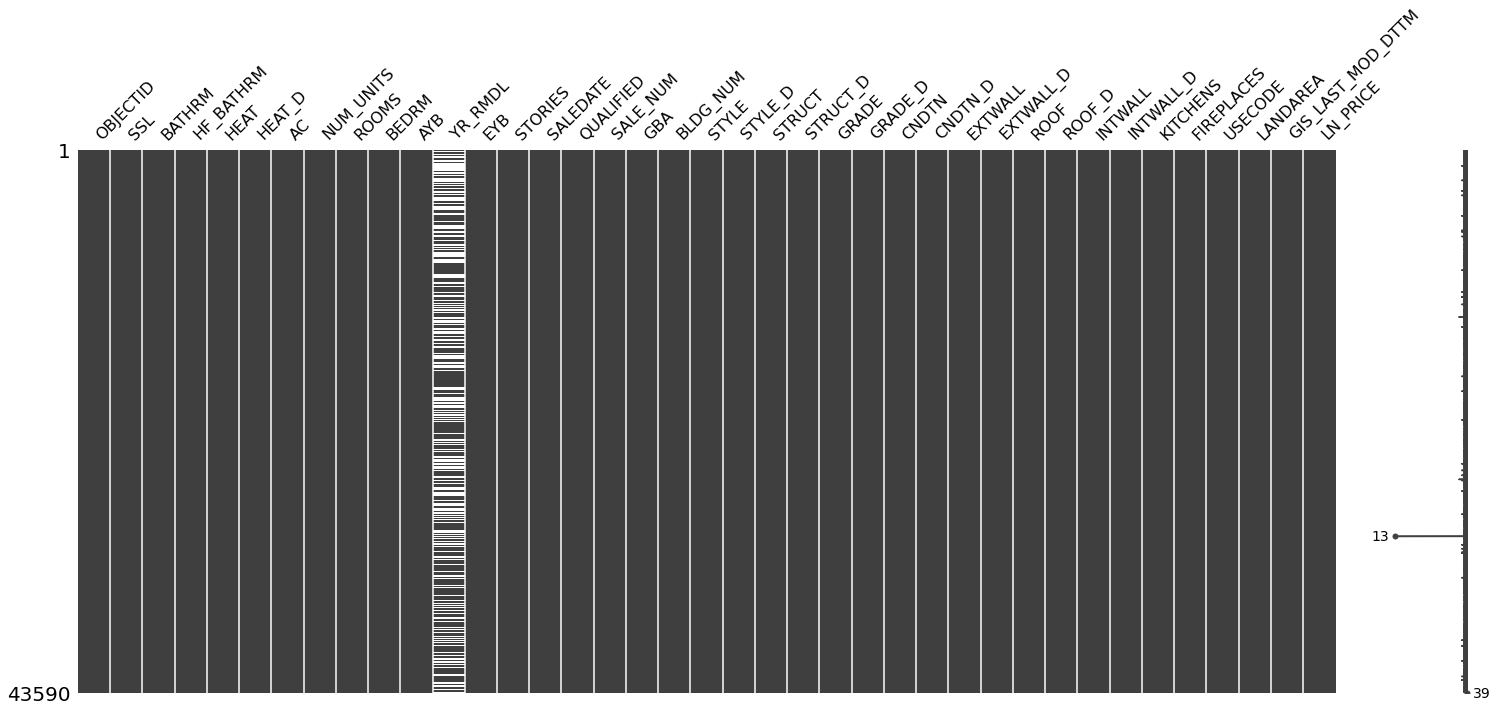

In [4]:
# Observe if we are missing any data in the training data.
miss.matrix(train_data)

In [5]:
# If house wasn't renovated, use the date the property was built. 
train_data['YR_RMDL'] = train_data['YR_RMDL'].fillna(train_data['AYB'])

<AxesSubplot:>

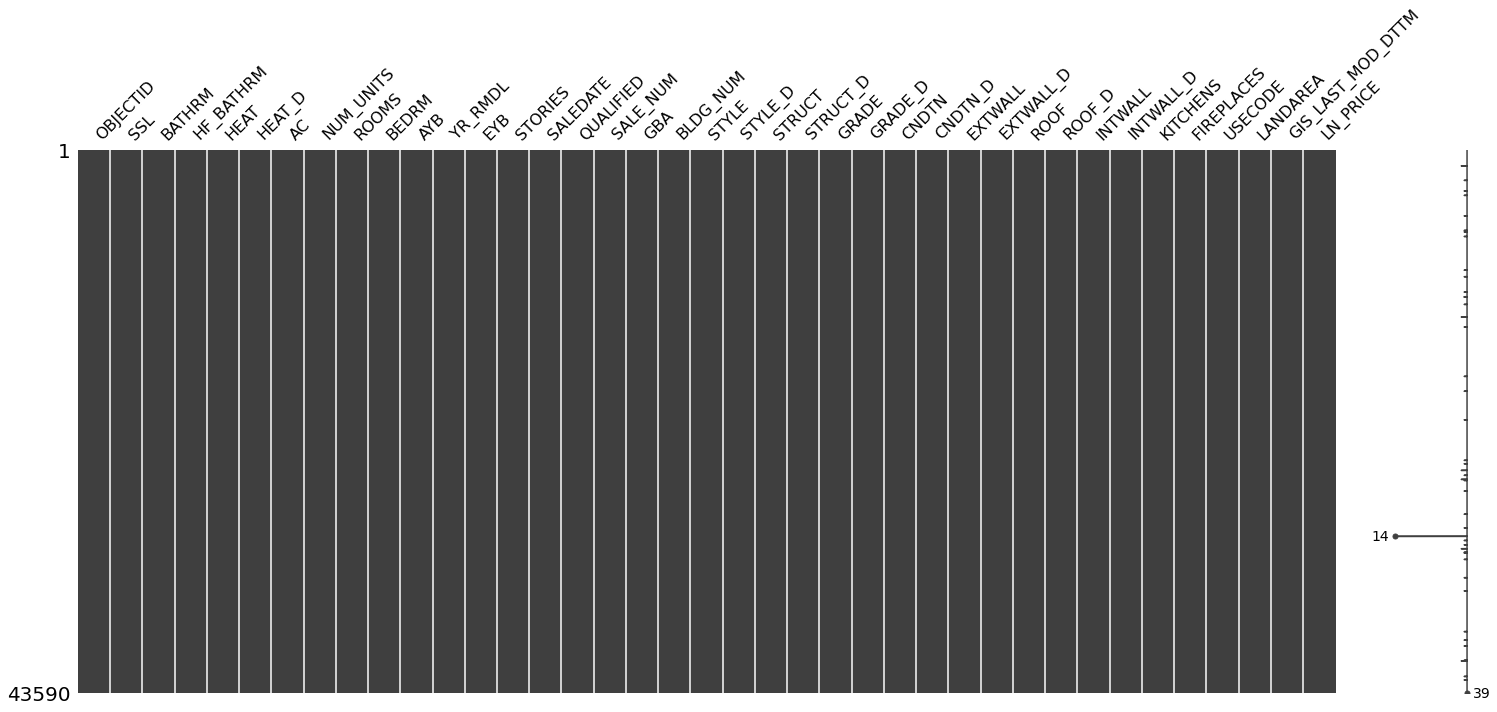

In [6]:
miss.matrix(train_data) # confirm that missing data is filled now

In [7]:
# Define the predictors we will use to predict the log selling price of a house in DC.
predic = ["YR_RMDL", "ROOMS", "BEDRM", "FIREPLACES", "KITCHENS"]

In [8]:
# Drop all observations where the outcome is missing for both training and test data.
# Only drop NAs for the predictors we are considering.
train_data = train_data.dropna(subset = predic)
test_data = test_data.dropna(subset = predic)

# Drop all observations where the outcome is missing 
train_data = train_data[~train_data.LN_PRICE.isna()]

# Only houses that are sold
train_data = train_data[train_data.LN_PRICE > 0]

# drop variables not to be used
train_data.drop(['BATHRM','AC','NUM_UNITS','AYB','EYB','STORIES','QUALIFIED','BLDG_NUM','STYLE_D','STRUCT_D','CNDTN_D','EXTWALL_D','OBJECTID','SSL','HF_BATHRM','HEAT','HF_BATHRM','GIS_LAST_MOD_DTTM','SALEDATE',
            'HEAT', 'HEAT_D','ROOF','ROOF_D','INTWALL','INTWALL_D','STYLE','GRADE',
            'GRADE_D','USECODE','GBA','SALE_NUM','LANDAREA','STRUCT','CNDTN','EXTWALL'],axis=1, inplace=True)

In [9]:
# Drop all observations where the outcome value is missing.
train_data = train_data[~train_data.LN_PRICE.isna()]
test_data = test_data[~test_data.LN_PRICE.isna()]

In [10]:
# Select homes that were sold
train_data = train_data[train_data.LN_PRICE > 0]
test_data = test_data[test_data.LN_PRICE > 0]

In [11]:
train_data.head(2)

,ROOMS,BEDRM,YR_RMDL,KITCHENS,FIREPLACES,LN_PRICE
0,9.0,4.0,2016.0,1.0,0.0,13.591116
1,7.0,3.0,1938.0,1.0,1.0,12.730801


In [12]:
# Split the data between training and test based on the defined predictors.
y_train = train_data.LN_PRICE
x_train = train_data[predic]

y_test = test_data.LN_PRICE
x_test = test_data[predic]

In [13]:
# Look at the training data.
x_train.shape

(43571, 5)

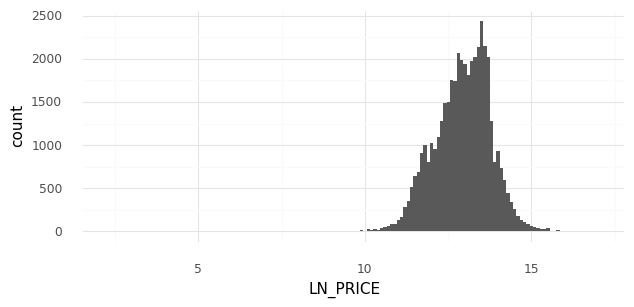

<ggplot: (319275960)>

In [14]:
# We explore the outcome LN_PRICE to see if there are any issues.
(
    ggplot(pd.DataFrame(dict(LN_PRICE = y_train)),
           aes(x = "LN_PRICE")) +
    geom_histogram(binwidth = 0.1) +
    theme_minimal() +
    theme(figure_size = (7, 3)) 
)

The distribution for the dependent variable is normally distributed and centered around 12-13 as visually discerned above.

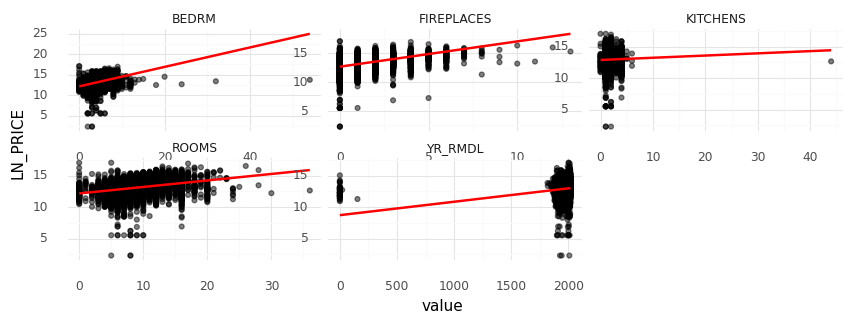

<ggplot: (319485175)>

In [15]:
# We explore how the predictors we have defined relate to the outcome LN_PRICE.

# First take a copy of the training data x-values.
D = x_train.copy()

# Pull in the outcomes from the training data y-values.
D["LN_PRICE"] = y_train

# We plot the predictors against the outcome LN_PRICE.
(
    ggplot(D.melt(id_vars = ["LN_PRICE"]),
           aes(x = "value",
               y = "LN_PRICE")) +
    geom_point(alpha = .5) +
    facet_wrap("variable",
               scales = "free") +
    geom_smooth(method = "lm",
                se = False,
                color = "red") +
    theme_minimal() +
    theme(figure_size = (10, 3)) 
)

Over the predictors in the dataset there seems to be a positive relationship of each to the dependent variable

# Model generation

In [16]:
# (A) Set the folds index to ensure comparable samples - set a seed to recreate same results over and over.
fold_generator = KFold(n_splits = 5, shuffle = True, random_state = 521)

# (B) Specify the preprocessing steps with the defined predictors from data
preprocess = ColumnTransformer(transformers = [("num", pp.MinMaxScaler(), predic)])

In [17]:
# (C) Create our model pipe where we leave the model as "None" to act as a placeholder.
pipe = Pipeline(steps=[("pre_process", preprocess),
                       ("model", None)])

In [18]:
# (D) Specify the models to be run and  respective tuning parameters.
search_space = [
    # Linear Model
    {"model" : [LM()]},
    
    # KNN with K tuning param
    {"model" : [KNN()],
     "model__n_neighbors" : [10, 15, 30, 90, 120]},
    
    # Decision Tree with the Max Depth param
    {"model" : [DTree()],
     "model__max_depth" : [1, 2, 3, 4, 5]},
    
    # The Bagging decision tree model 
    {"model" : [Bag()]},
    
    # Random forest with the N Estimators and Max Depth tuning params
    {"model" : [RF()],
     "model__max_depth" : [1, 2, 3, 4, 5],
     "model__n_estimators" : [500, 1000, 1250, 1500]}
]

# (E) Peice together in grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=5)

# (F) Fit the model to the training data
search.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=521, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['YR_RMDL',
                                                                          'ROOMS',
                                                                          'BEDRM',
                                                                          'FIREPLACES',
                                                                          'KITCHENS'])])),
                                       ('model', None)]),
             n_jobs=5,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': [10, 15, 30, 90, 120]},
        

In [19]:
# Identify the best model out of the search.
search.best_params_

{'model': RandomForestRegressor(max_depth=5, n_estimators=500),
 'model__max_depth': 5,
 'model__n_estimators': 500}

In [20]:
# Use the "predict" method which uses the best model out of the scan.
y_pred = search.predict(x_test)

In [21]:
# Report the mean squared error.
m.mean_squared_error(y_test, y_pred)

0.41090743691105686

In [22]:
# Report the r-squared value.
m.r2_score(y_test, y_pred)

0.32194058377592094

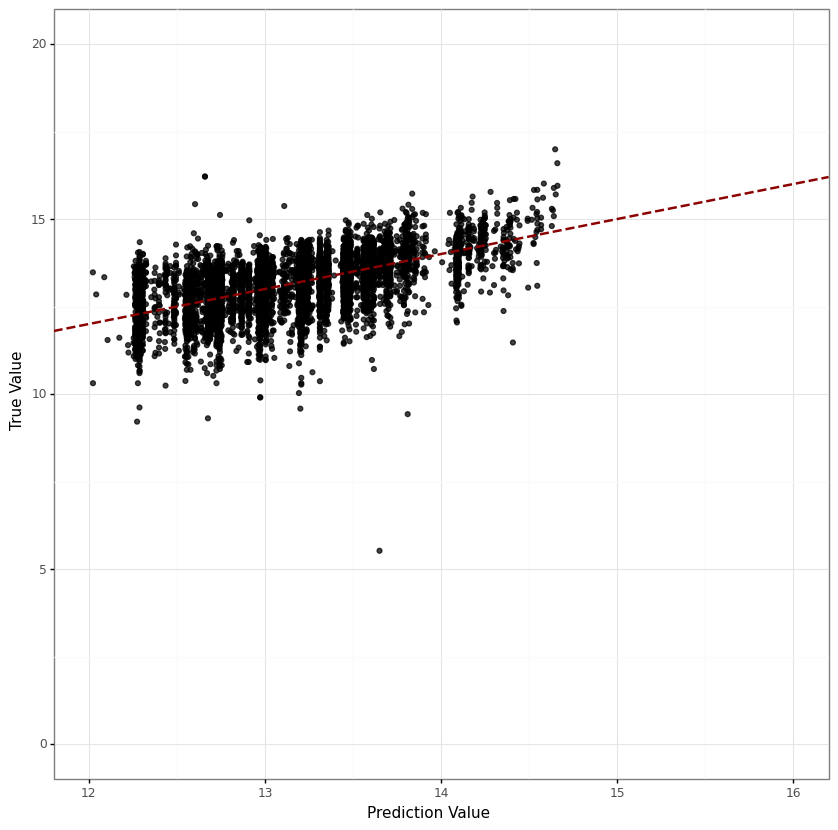

<ggplot: (319339002)>

In [23]:
# We plot the predicted values to the true values of LN_PRICE in order to observe how well our model performs.
(
    ggplot(pd.DataFrame(dict(pred = y_pred,
                             true = y_test)),
          aes(x = "pred",
              y = "true")) +
    xlab("Prediction Value") +
    xlim(12, 16) +
    ylim(0, 20) +
    ylab("True Value") +
    geom_point(alpha = .75) +
    geom_abline(linetype = "dashed",
                color = "darkred",
                size = 1) +
    theme_bw() +
    theme(figure_size = (10, 10))
)

The best model that came from this estimation was the random forest which had a depth of 5 and 500 estimators. The overall means squared errors is about ~0.41. Unfortunately the r_squared value is lower than would be ideal because it 